# Summary
There are two parts to how a movement between point A and point B might vary. The first is variance in the actual movement path taken to get from point A to point B, and the second is the speed of the movement. Here, I'll analyze the movement path variance, `var_p`, across all __Hit__ trials from 1 day. I will define a `movement` as the recorded lever movement between a defined first and second threshold. I will then plot the variance of this path, `var_p`, over the % movement completion between the first and second threshold. I also calculate the average movement path, `mean_p`, for this 1 day.

### imports:

In [3]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

import pickle # save data
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name`

In [4]:
# for all .mat files in this folder starting with "ToneDisc_ANChandler_p1_" in their name
folder_name = './Chandler/Phase1/ToneDisc_ANChandler_p1_'

### sort through relevant .mat files found in folder by day ("_d#")

In [5]:
unsorted_mat_files = glob.glob(folder_name+'*.mat')
sorted_mat_files = sorted(unsorted_mat_files, key=lambda x: int(re.search(r'\d+.mat$',x).group()[:-4]))
sorted_mat_files

['./Chandler/Phase1/ToneDisc_ANChandler_p1_d1.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d2.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d3.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d4.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d5.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d6.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d7.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d8.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d9.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d10.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d11.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d12.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d13.mat',
 './Chandler/Phase1/ToneDisc_ANChandler_p1_d14.mat']

### extract one day's data from corresponding .mat file

In [6]:
day = -1
mat_file_string = sorted_mat_files[day]
mat_dict = io.loadmat(mat_file_string)

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### find all movements from trials that meet both thresholds, and move these movements into `movements`

`movements`: each row is a movement, 3 columns `trial_i` |  `first_threshold_arduino_i` | `second_threshold_arduino_i`

In [7]:
# get `respMTX` (trials) and `dataArduino` from response
dataArduino = response[0]
#print("dataArduino shape: "+str(dataArduino.shape))
respMTX = response[2]
#print("MTXTrialType shape: "+str(MTXTrialType.shape))
num_trials = respMTX.shape[0]

decision = params[6][0][0][2][0][0]

movements = np.array([]).reshape(0,5)
for trial_i in range(0, num_trials):
    if ~np.isnan(respMTX[trial_i, 1]):
        # get the row in dataArduino for tone_t
        tone_t = respMTX[trial_i, 1]
        for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
            if tone_t <= arduino_t:
                tone_arduino_i = arduino_i
                break
        
        # get the row in dataArduino for tone_t
        decision_end_t = tone_t + decision
        for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
            if decision_end_t <= arduino_t:
                decision_end_arduino_i = arduino_i
                break
        
        # first threshold is just timePressed for now
        first_threshold_arduino_i = 0
        first_threshold = 0
        if ~np.isnan(respMTX[trial_i, 3]):
            for arduino_i, arduino_t in enumerate(dataArduino[:, 0]):
                if respMTX[trial_i, 3] <= arduino_t:
                    first_threshold_arduino_i = arduino_i
                    first_threshold = dataArduino[first_threshold_arduino_i, 1]
                    break
        
        # second threshold for now
        second_threshold_arduino_i = 0
        if first_threshold != 0:
            second_threshold = first_threshold-0.25
            for arduino_i, arduino_data in enumerate(dataArduino[\
                first_threshold_arduino_i:decision_end_arduino_i, 1]):
                if second_threshold >= arduino_data:
                    second_threshold_arduino_i = arduino_i + first_threshold_arduino_i
                    break
        
        # if both first threshold and second threshold are met, add to movements
        if (first_threshold_arduino_i != 0) and (second_threshold_arduino_i !=0):
            print("adding movement from trial: ",trial_i)
            movements = np.vstack((movements, np.array([trial_i, \
                first_threshold_arduino_i, \
                second_threshold_arduino_i, \
                first_threshold, \
                second_threshold, \
            ])\
            ))
        

adding movement from trial:  8
adding movement from trial:  11
adding movement from trial:  17
adding movement from trial:  26
adding movement from trial:  33
adding movement from trial:  45
adding movement from trial:  84
adding movement from trial:  197


### check what `movements` looks like

In [8]:
print("number of extracted_movements ", len(movements))
print(movements)

number of extracted_movements  8
[[ 8.00000e+00  8.04500e+03  8.07600e+03 -2.61170e+00 -2.86170e+00]
 [ 1.10000e+01  1.31580e+04  1.31640e+04 -2.55290e+00 -2.80290e+00]
 [ 1.70000e+01  1.96240e+04  1.96710e+04 -2.35200e+00 -2.60200e+00]
 [ 2.60000e+01  3.31520e+04  3.31930e+04 -2.22460e+00 -2.47460e+00]
 [ 3.30000e+01  4.65550e+04  4.65690e+04 -2.54310e+00 -2.79310e+00]
 [ 4.50000e+01  6.34990e+04  6.35130e+04 -2.39120e+00 -2.64120e+00]
 [ 8.40000e+01  1.23157e+05  1.23159e+05 -2.27850e+00 -2.52850e+00]
 [ 1.97000e+02  2.73432e+05  2.73449e+05 -2.27850e+00 -2.52850e+00]]


### remove baselines and align temporally for each `movement` in `movements` and put into `movements_dataArduino`

so `movements_dataArduino` is a list of `movement_dataArduino`'s.

for example, `movements_dataArduino[0]`: for movement 0, this is a list where first elem is times and second elem is lever movements,

aligned so that the first threshold = 0 on the y-axis, and time at which the first threshold is met = 0 on the x-axis



In [9]:
movements_dataArduino = []
for movement in movements:
    movements_dataArduino.append([
        dataArduino[int(movement[1]):int(movement[2])+1,0]-dataArduino[int(movement[1]),0],\
        dataArduino[int(movement[1]):int(movement[2])+1,1] - dataArduino[int(movement[1]), 1]\
            ])

check by plotting:

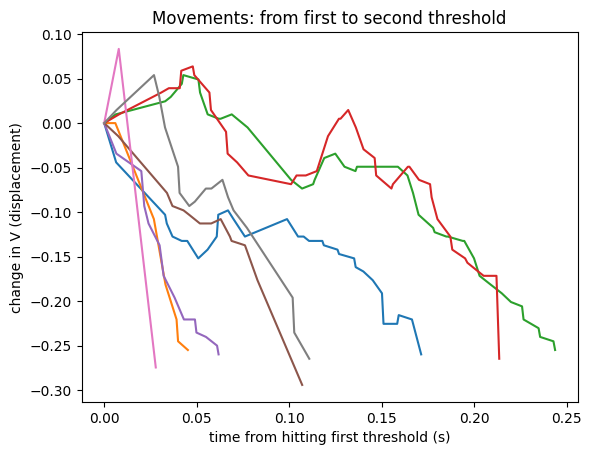

In [10]:
for movement_dataArduino in movements_dataArduino:
    # also check by plotting all of the movements
    plt.plot(\
        movement_dataArduino[0],\
        movement_dataArduino[1]\
        )
plt.title("Movements: from first to second threshold")
plt.xlabel("time from hitting first threshold (s)")
plt.ylabel("change in V (displacement)")
plt.show()

### linear interpolation fcn:
- takes `oldx`, `oldy`, `num_samples`
- returns `newx`, `newy`, where `newx` is the range from the beginning of `oldx` to whereever `oldy` hits the second threshold (e.g. -0.25V from the first threshold)

In [11]:
def interpolate_dataArduino(oldx, oldy, num_samples):
    f = interpolate.interp1d(oldx, oldy, kind='linear')

    # find interpolated value of x for second threshold
    for x in np.linspace(min(oldx), max(oldx), num_samples*10):
        if f(x) < -0.25:
            newx_max = x
            break
    
    newx = np.linspace(min(oldx), newx_max, num_samples)
    newy = f(newx)
    return newx, newy

### interpolate `movement_dataArduinos` from `movements_dataArduino` and store in `interpolated_movements_dataArduino`

`interpolated_movement_dataArduino`: for movement 0, the movement displacement (e.g. 0V to -0.25V) in 100 samples

`interpolated_time_dataArduino`: 0 to however long the movement took in 100 samples

In [29]:
num_samples = 100
interpolated_movements_dataArduino=np.array([]).reshape(0,num_samples)
interpolated_times_dataArduino=np.array([]).reshape(0,num_samples)
for movement_i, movement_dataArduino in enumerate(movements_dataArduino):
    interpolated_time_dataArduino, interpolated_movement_dataArduino = interpolate_dataArduino(movement_dataArduino[0], movement_dataArduino[1], num_samples)
    interpolated_movements_dataArduino = np.vstack((\
        interpolated_movements_dataArduino, interpolated_movement_dataArduino\
            ))
    interpolated_times_dataArduino = np.vstack((\
        interpolated_times_dataArduino, interpolated_time_dataArduino\
            ))

### Plot the movement paths across % movement completed as the x-axis

Text(0.5, 1.0, 'Movement paths from first to second threshold (1 day)')

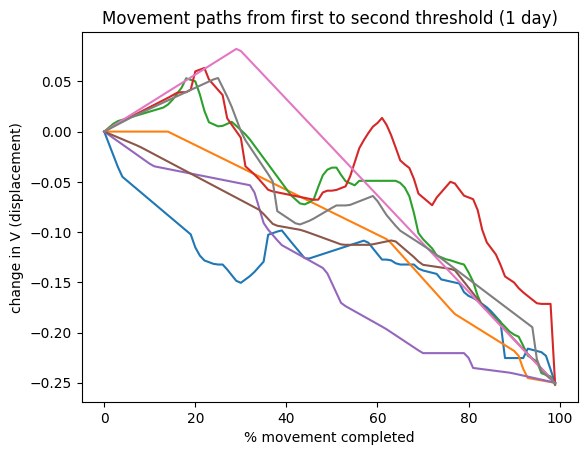

In [30]:
for interpolated_movement_dataArduino in interpolated_movements_dataArduino:
    plt.plot(range(0,100), interpolated_movement_dataArduino)
plt.xlabel("% movement completed")
plt.ylabel("change in V (displacement)")
plt.title("Movement paths from first to second threshold (1 day)")

### calculate the movement path variance, `var_p`, across each `interpolated_movement_dataArduino`

In [31]:
var_p=np.var(interpolated_movements_dataArduino, axis=0)

plot `var_p` across % movement completed

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold for this day')

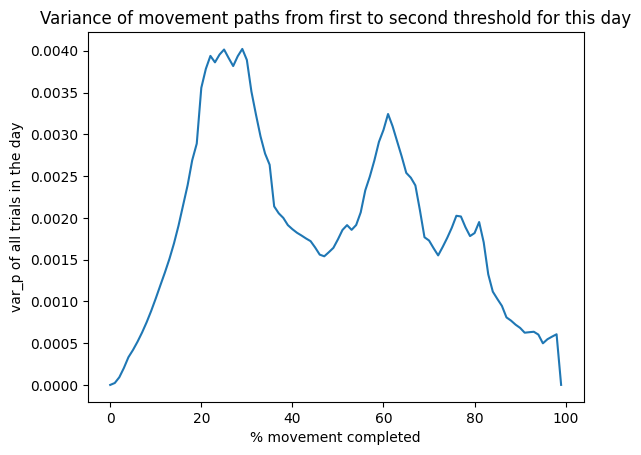

In [32]:
plt.plot(range(0,100), var_p)
plt.xlabel("% movement completed")
plt.ylabel("var_p of all trials in the day")
plt.title("Variance of movement paths from first to second threshold for this day")

### Also calculate the average movement path, `mean_ps`, across each `interpolated_movement_dataArduino`

In [33]:
mean_p=np.mean(interpolated_movements_dataArduino, axis=0)

plot `mean_p` across % movement completed

Text(0.5, 1.0, 'Mean movement path from first to second threshold for this day')

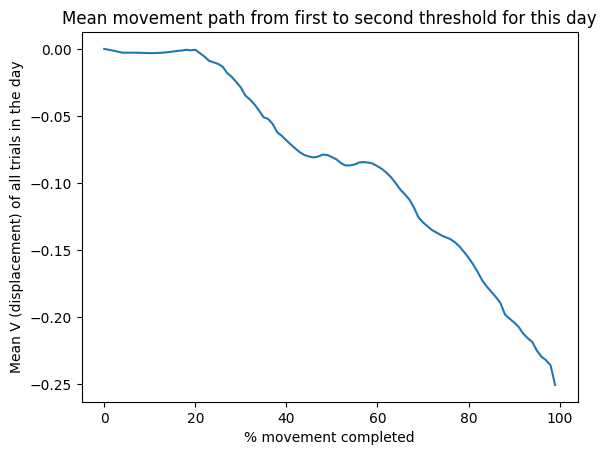

In [34]:
plt.plot(range(0,100), mean_p)
plt.xlabel("% movement completed")
plt.ylabel("Mean V (displacement) of all trials in the day")
plt.title("Mean movement path from first to second threshold for this day")

### save `movements_dataArduino`, `interpolated_movements_dataArduino`, and `movements_var_ps`

In [35]:
file = open(mat_file_string+'_interpolated_times_dataArduino.pickle', 'wb')
pickle.dump(interpolated_times_dataArduino, file)
file.close()

file = open(mat_file_string+'_interpolated_movements_dataArduino.pickle', 'wb')
pickle.dump(interpolated_movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_movements_dataArduino.pickle', 'wb')
pickle.dump(movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_var_p.pickle', 'wb')
pickle.dump(var_p, file)
file.close()

file = open(mat_file_string+'_mean_p.pickle', 'wb')
pickle.dump(mean_p, file)
file.close()